In [2]:
import numpy as np
import matplotlib.pyplot as plt
from util.plot import plot_cdf,plot_lines,plot_box_by_config,plot_box,plot_grouped_boxplots,plot_scatter
from util.consts import balance_size_bins, balance_size_bins_label
from util.plot import color_list
import json
import os
from collections import defaultdict
import csv

flowsim-sldn: (1, 50000), actual_sldn: (1, 50000), sizes: (50000,)
m4_10-sldn: (1, 50000), actual_sldn: (1, 50000), sizes: (50000,)


/data1/lichenni/projects/per-flow-sim/util/plot.py:110: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(
/data1/lichenni/projects/per-flow-sim/util/plot.py:110: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(
/data1/lichenni/projects/per-flow-sim/util/plot.py:110: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(


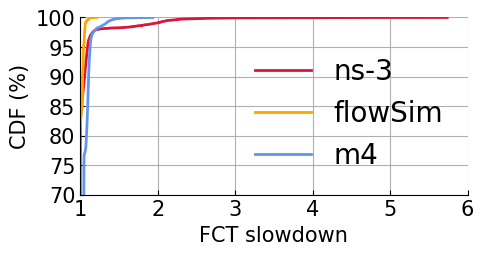

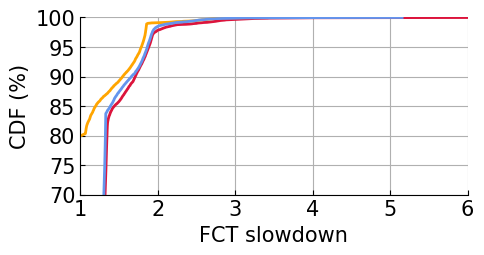

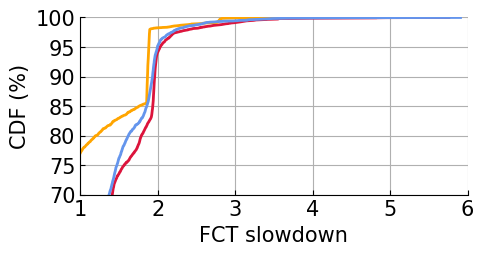

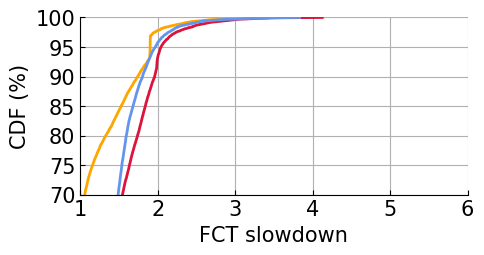

In [3]:
size_bins = [0, 1 * 1024, 200 * 1024, 1024 * 1024, np.inf]  # Sizes in bytes
size_bin_labels = ['<=1KB', '1KB-200KB','200KB-1MB', '1MB']
legend_list=['ns-3','flowSim','m4']
model_instance_list=['flowsim',"m4_10"]
n_methods = len(legend_list)
fig_index=0
for scenario_idx in [1]:
    empirical_str = f"_large{scenario_idx}"
    
    sizes=np.load(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_7/data/{scenario_idx}/ns3/fsize.npy')

    error_list=[]
    error_size_list=[]
    for model_idx,model_instance in enumerate(model_instance_list):
        data_m4 = np.load(f'./res/{model_instance}{empirical_str}.npz')
        sldn = data_m4['sldn']
        predicted_sldns = sldn[:, :, 0]
        actual_sldns = sldn[:,:, 1]
        print(f"{model_instance}-sldn: {predicted_sldns.shape}, actual_sldn: {actual_sldns.shape}, sizes: {sizes.shape}")
        assert predicted_sldns.size == actual_sldns.size==sizes.size
        
        if model_idx==0:
            error_list.extend([actual_sldns,predicted_sldns])
            error_size_list.extend([sizes,sizes])
        else:
            error_list.append(predicted_sldns)
            error_size_list.append(sizes)

    # Initialize a dictionary to store errors per size bucket for each model instance
    error_bins = {legend: {label: np.array([]) for label in size_bin_labels} for legend in legend_list}

    # Process the data for each model instance
    for mi in range(n_methods):
        legend = legend_list[mi]
        errors = error_list[mi]  # Shape: (n_scenarios, n_flows)
        sizes = error_size_list[mi]  # Shape: (n_scenarios, n_flows)

        # Flatten the arrays
        errors_flat = errors.flatten()
        sizes_flat = sizes.flatten()

        # Assign flows to size buckets
        size_indices = np.digitize(sizes_flat, size_bins)

        # Collect errors for each size bucket
        for b in range(1, len(size_bins)):
            bin_mask = size_indices == b
            bin_errors = errors_flat[bin_mask]
            error_bins[legend][size_bin_labels[b - 1]] = np.concatenate((error_bins[legend][size_bin_labels[b - 1]], bin_errors))

    # Plot the CDF of errors for each size bucket
    for idx, size_bin_label in enumerate(size_bin_labels):
        plot_data=[]
        for mi, legend in enumerate(legend_list):
            bin_errors = error_bins[legend][size_bin_label]
            plot_data.append(bin_errors)
        plot_cdf(plot_data,f'./figs/eva_large_scale_cdf_{idx}.pdf',legend_list if idx==0 else [],'FCT slowdown',legend_font=20,group_size=3,loc=4,rotate_xaxis=False,ylim_low=70,log_switch=False,xlim_bottom=1, fig_idx=fig_index,xlim=6)
        fig_index+=1

-----------------
flowsim_large0-sldn: (50000,)
p99 slowdown: 2.6191770862119705, 3.1470952869399285
m4_10_large0-sldn: (50000,)
p99 slowdown: 2.926267228126527, 3.1470952869399285
mean error:[14.164662769836996, 6.572323480596993]
p90 error: [31.774261743320064, 13.716289462564882]
p99 sldn error: [16.7747765   7.01688505]
-----------------
flowsim_large1-sldn: (50000,)
p99 slowdown: 1.981413368370801, 2.4446422045198695
m4_10_large1-sldn: (50000,)
p99 slowdown: 2.20815957069397, 2.4446422045198695
mean error:[13.771940940418444, 4.787131453509162]
p90 error: [30.609013589144396, 9.573342541225545]
p99 sldn error: [18.94873758  9.67350696]


/data1/lichenni/projects/per-flow-sim/util/plot.py:306: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(
/data1/lichenni/projects/per-flow-sim/util/plot.py:306: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(


-----------------
flowsim_large2-sldn: (50000,)
p99 slowdown: 2.0141809455496893, 2.8049915356111943
m4_10_large2-sldn: (50000,)
p99 slowdown: 2.613960115909577, 2.8049915356111943
mean error:[8.763318744428156, 7.039535423848213]
p90 error: [28.7425776651722, 13.41366046571079]
p99 sldn error: [28.19297599  6.81040985]


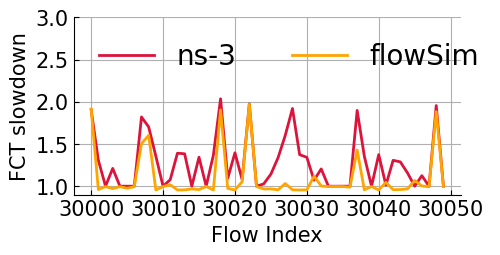

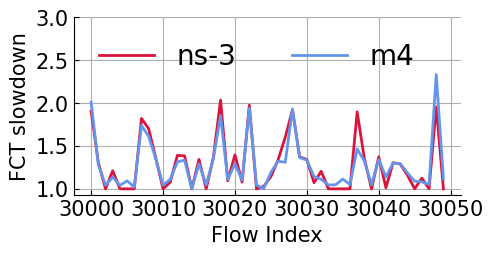

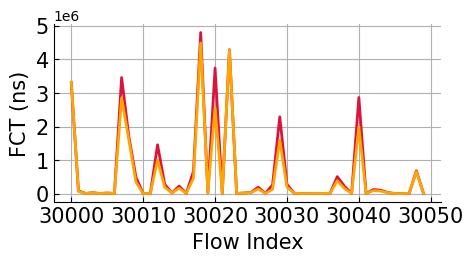

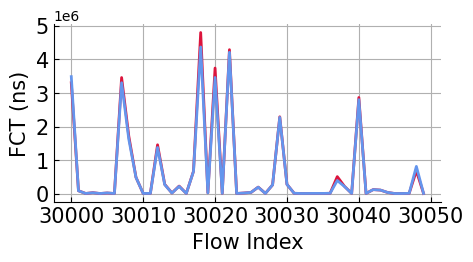

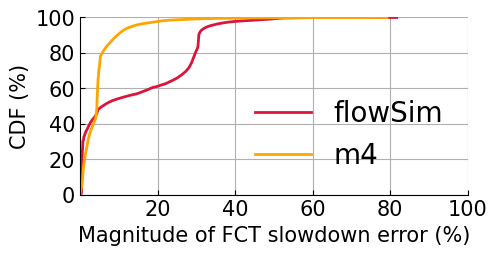

In [17]:
empirical_str = ""

legend_list=['flowSim','m4']
for scenario_idx,scenario_str in enumerate(["_large0","_large1","_large2"]):
    model_instance_list=[f'flowsim{empirical_str}{scenario_str}',f'm4_10{empirical_str}{scenario_str}']
    error_list=[]
    error_list_p99=[]
    sldn_list=[]
    fct_list=[]
    print(f"-----------------")
    for model_instance in model_instance_list:
        data_m4 = np.load(f'./res/{model_instance}.npz')
        sldn = data_m4['sldn']
        predicted_sldns = sldn[:, :, 0].squeeze()
        actual_sldns = sldn[:,:, 1].squeeze()
        print(f"{model_instance}-sldn: {predicted_sldns.shape}")
        
        fct=data_m4['fct']
        predicted_fcts = fct[:, :, 0].squeeze()
        actual_fcts = fct[:,:, 1].squeeze()
        
        # calculate the relative error
        relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
        sldn_list.append([actual_sldns,predicted_sldns])
        fct_list.append([actual_fcts,predicted_fcts])
        error_list.append(relative_error_sldn)
        
        sldn_p99_est=np.percentile(predicted_sldns,99)
        sldn_p99_act=np.percentile(actual_sldns,99)
        print(f"p99 slowdown: {sldn_p99_est}, {sldn_p99_act}")
        error_list_p99.append(np.abs(sldn_p99_est-sldn_p99_act)/sldn_p99_act*100)
    error_list=np.array(error_list)
    error_list_p99=np.array(error_list_p99)
    sldn_list=np.array(sldn_list)
    fct_list=np.array(fct_list)
    print(f"mean error:{[np.mean(x) for x in error_list]}")
    print(f"p90 error: {[np.percentile(x,90) for x in error_list]}")
    print(f"p99 sldn error: {error_list_p99}")
    
    if scenario_idx==1:  
        fig_idx=0
        data_x=np.arange(30000, 30050)
        linelabels = [["ns-3","flowSim"],["ns-3","m4"]]
        format_idx=[[0,1],[0,2]]
        for i, (actual, predicted) in enumerate(sldn_list):
            plot_data=[(data_x,actual[data_x]),(data_x,predicted[data_x])]
            plot_lines(
                plot_data,
                f'./figs/eva_large_scale_line_sldn_{i}.pdf',
                linelabels[i],
                x_label="Flow Index",
                y_label="FCT slowdown",
                title=None,
                ylim=3,
                format_idx=format_idx[i],
                legend_cols=2,
                legend_font=20,
                fig_idx=fig_idx,
            )
            fig_idx+=1

        for i, (actual, predicted) in enumerate(fct_list):
            plot_data=[(data_x,actual[data_x]),(data_x,predicted[data_x])]
            plot_lines(
                plot_data,
                f'./figs/eva_large_scale_line_fct_{i}.pdf',
                [],
                x_label="Flow Index",
                y_label="FCT (ns)",
                title=None,
                # log_switch=True,
                # ylim=6,
                format_idx=format_idx[i],
                legend_cols=1,
                legend_font=20,
                fig_idx=fig_idx,
            )
            fig_idx+=1
            
        plot_cdf(
            error_list,
            f'./figs/eva_large_scale_cdf.pdf',
            legend_list,
            x_label="Magnitude of FCT slowdown error (%)",
            log_switch=False,
            rotate_xaxis=False,
            xlim=100,
            xlim_bottom=0.01,
            fontsize=15,
            legend_font=20,
            loc=4,
            enable_abs=True,
            group_size=5,
            fig_idx=fig_idx
        )

-----------------
flowsim_large3-sldn: (50000,)
p99 slowdown: 2.88813363553349, 4.037846210242044
m4_10_large3-sldn: (50000,)
p99 slowdown: 3.9605025434494054, 4.037846210242044
mean error:[13.680802670081391, 10.635609582147374]
p90 error: [32.38092824009751, 27.387103381088934]
p99 sldn error: [28.47341169  1.91546837]


/data1/lichenni/projects/per-flow-sim/util/plot.py:306: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(
/data1/lichenni/projects/per-flow-sim/util/plot.py:306: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(


-----------------
flowsim_large4-sldn: (50000,)
p99 slowdown: 2.4253359334937667, 2.864284060873343
m4_10_large4-sldn: (50000,)
p99 slowdown: 2.641700050830845, 2.864284060873343
mean error:[13.707509138235606, 6.015338663428447]
p90 error: [31.14267315571814, 12.384924428556408]
p99 sldn error: [15.32488112  7.77101731]
-----------------
flowsim_large5-sldn: (50000,)
p99 slowdown: 2.494160591586206, 3.092415652095125
m4_10_large5-sldn: (50000,)
p99 slowdown: 3.5371298599243177, 3.092415652095125
mean error:[9.164775661149395, 8.730411965957979]
p90 error: [29.06610369018189, 22.803539646787115]
p99 sldn error: [19.34588127 14.38080316]


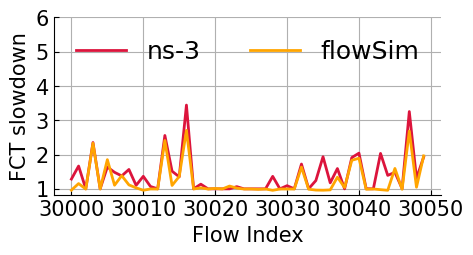

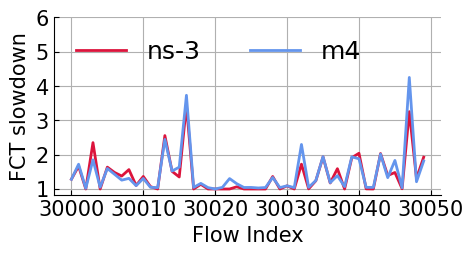

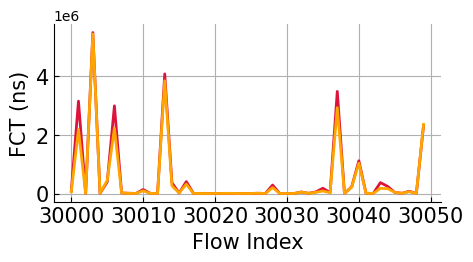

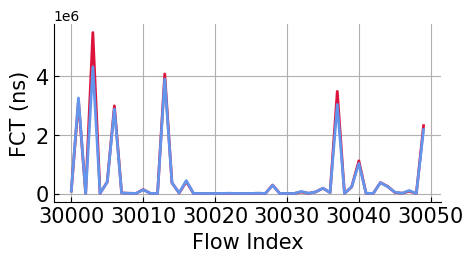

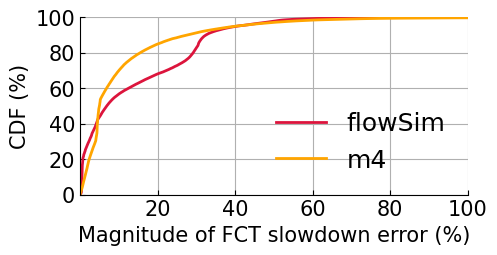

In [8]:
empirical_str = ""

legend_list=['flowSim','m4']
for scenario_idx,scenario_str in enumerate(["_large3","_large4","_large5"]):
    model_instance_list=[f'flowsim{empirical_str}{scenario_str}',f'm4_10{empirical_str}{scenario_str}']
    error_list=[]
    error_list_p99=[]
    sldn_list=[]
    fct_list=[]
    print(f"-----------------")
    for model_instance in model_instance_list:
        data_m4 = np.load(f'./res/{model_instance}.npz')
        sldn = data_m4['sldn']
        predicted_sldns = sldn[:, :, 0].squeeze()
        actual_sldns = sldn[:,:, 1].squeeze()
        print(f"{model_instance}-sldn: {predicted_sldns.shape}")
        
        fct=data_m4['fct']
        predicted_fcts = fct[:, :, 0].squeeze()
        actual_fcts = fct[:,:, 1].squeeze()
        
        # calculate the relative error
        relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
        sldn_list.append([actual_sldns,predicted_sldns])
        fct_list.append([actual_fcts,predicted_fcts])
        error_list.append(relative_error_sldn)
        
        sldn_p99_est=np.percentile(predicted_sldns,99)
        sldn_p99_act=np.percentile(actual_sldns,99)
        print(f"p99 slowdown: {sldn_p99_est}, {sldn_p99_act}")
        error_list_p99.append(np.abs(sldn_p99_est-sldn_p99_act)/sldn_p99_act*100)
    error_list=np.array(error_list)
    error_list_p99=np.array(error_list_p99)
    sldn_list=np.array(sldn_list)
    fct_list=np.array(fct_list)
    print(f"mean error:{[np.mean(x) for x in error_list]}")
    print(f"p90 error: {[np.percentile(x,90) for x in error_list]}")
    print(f"p99 sldn error: {error_list_p99}")
    
    if scenario_idx==0:  
        fig_idx=0
        data_x=np.arange(30000, 30050)
        linelabels = [["ns-3","flowSim"],["ns-3","m4"]]
        format_idx=[[0,1],[0,2]]
        for i, (actual, predicted) in enumerate(sldn_list):
            plot_data=[(data_x,actual[data_x]),(data_x,predicted[data_x])]
            plot_lines(
                plot_data,
                # f'./figs/eva_large_scale_line_sldn_{i}.pdf',
                None,
                linelabels[i],
                x_label="Flow Index",
                y_label="FCT slowdown",
                title=None,
                ylim=6,
                format_idx=format_idx[i],
                legend_cols=2,
                legend_font=18,
                fig_idx=fig_idx,
            )
            fig_idx+=1

        for i, (actual, predicted) in enumerate(fct_list):
            plot_data=[(data_x,actual[data_x]),(data_x,predicted[data_x])]
            plot_lines(
                plot_data,
                # f'./figs/eva_large_scale_line_fct_{i}.pdf',
                None,
                [],
                x_label="Flow Index",
                y_label="FCT (ns)",
                title=None,
                # log_switch=True,
                # ylim=6,
                format_idx=format_idx[i],
                legend_cols=2,
                legend_font=18,
                fig_idx=fig_idx,
            )
            fig_idx+=1
            
        plot_cdf(
            error_list,
            # f'./figs/eva_large_scale_cdf.pdf',
            None,
            legend_list,
            x_label="Magnitude of FCT slowdown error (%)",
            log_switch=False,
            rotate_xaxis=False,
            xlim=100,
            xlim_bottom=0.01,
            fontsize=15,
            legend_font=18,
            loc=4,
            enable_abs=True,
            group_size=5,
            fig_idx=fig_idx
        )

flowsim-sldn: (100, 20000)
m4_10-sldn: (100, 20000)


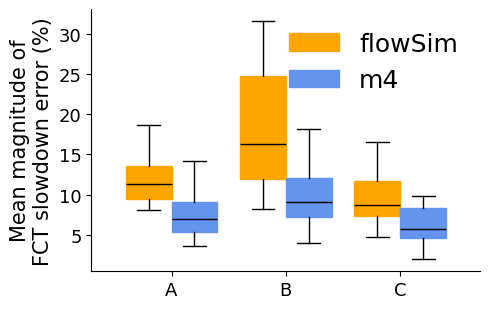

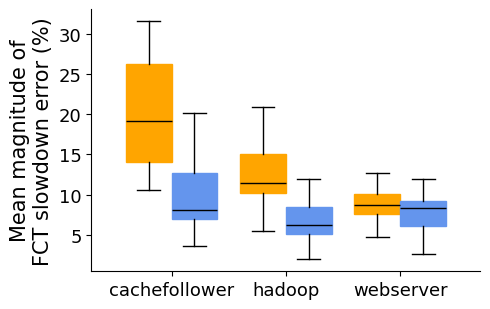

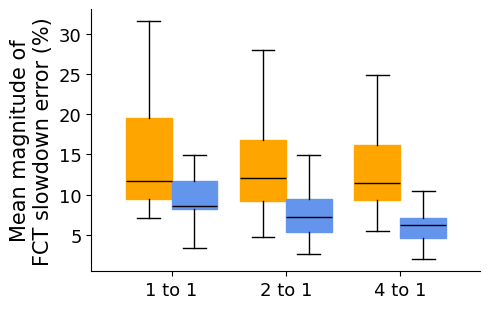

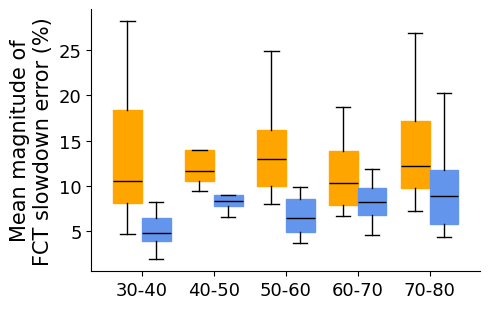

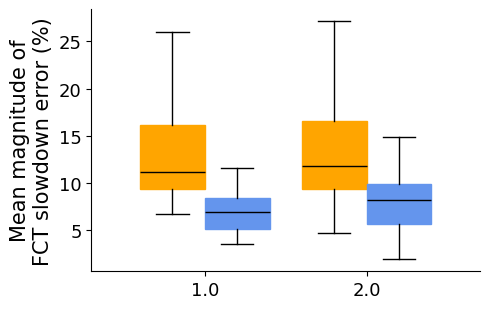

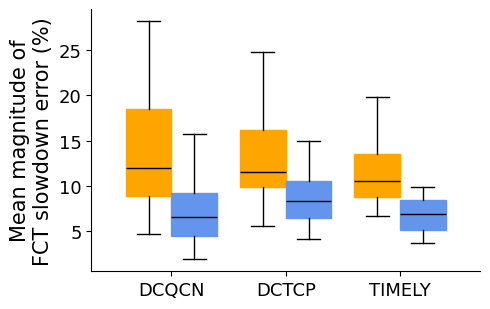

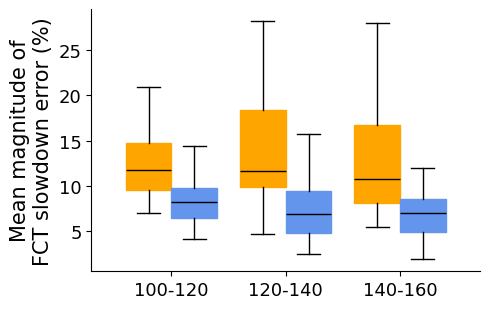

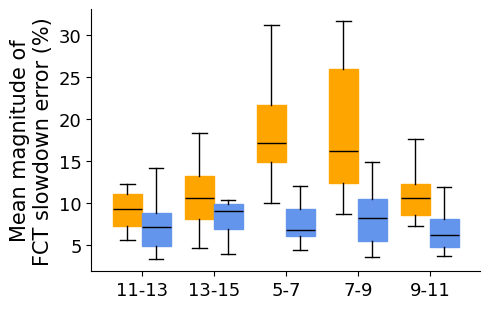

In [20]:
n_scenario=100
empirical_str = "eval_test"
legend_list=['flowSim','m4']
model_instance_list=['flowsim','m4_10']
                     
n_methods = len(legend_list)
config_file=f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/spec/eval_test.mix.json'
configs=json.load(open(config_file))

index_list_ori=[]
for i in range(n_scenario):
    if os.path.exists(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/{empirical_str}/{i}/ns3/flowsim_fct.npy'):
        sizes=np.load(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/{empirical_str}/{i}/ns3/fsize.npy')
        fcts=np.load(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/{empirical_str}/{i}/ns3/fct_topology_flows.npy')
        if sizes.size==fcts.size:
            index_list_ori.append(i)
index_list=[]
config_list=[]
for idx,i in enumerate(index_list_ori):
    config=configs[i]
    spatial=config['spatial'].split('/')[-1].split('.')[0].split('_')[1].upper()
    size_dist=config['size_dist'].split('/')[-1].split('.')[0].split('-')[0]
    cluster=config['cluster'].split('/')[-1].split('.')[0].split('_')
    cluster=f"{cluster[1]} to {cluster[3]}"
    max_load=float(config['max_load'])
    lognorm_sigma=float(config['lognorm_sigma'])
    cc=config['cc'].upper()
    bfsz=float(config['bfsz'])
    fwin=float(config['window'])
    
    config_list.append([spatial, size_dist, cluster, max_load, lognorm_sigma,cc,bfsz,fwin])
    index_list.append(idx)
config_list=np.array(config_list)

error_list=[]
error_list_p99=[]
for model_instance in model_instance_list:
    data_m4 = np.load(f'./res/{model_instance}{empirical_str}.npz')
    sldn = data_m4['fct']
    predicted_sldns = sldn[index_list, :, 0]
    actual_sldns = sldn[index_list,:, 1]
    print(f"{model_instance}-sldn: {predicted_sldns.shape}")
    
    predicted_sldns[predicted_sldns==0]=1
    actual_sldns[actual_sldns==0]=1
    # calculate the relative error
    relative_error_sldn = np.mean(np.abs(actual_sldns - predicted_sldns) / actual_sldns *100, axis=1)
    # relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
    sldn_p99_est=np.percentile(predicted_sldns,99,axis=1)
    sldn_p99_act=np.percentile(actual_sldns,99,axis=1)
    
    error_list.append(relative_error_sldn)
    error_list_p99.append(np.abs(sldn_p99_est-sldn_p99_act)/sldn_p99_act*100)
config_list=config_list[index_list]
error_list=np.array(error_list)
error_list_p99=np.array(error_list_p99)

fig_idx=0

# Discretize the max_load values
max_load_values = np.array([config[3] for config in config_list], dtype=float)
bins = [0.3,0.4, 0.5, 0.6, 0.70,0.80]
labels = ['30-40', '40-50', '50-60', '60-70','70-80']
max_load_bins = np.digitize(max_load_values, bins, right=False) - 1
max_load_labels = [labels[i] for i in max_load_bins]
for idx, config in enumerate(config_list):
    config[3] = max_load_labels[idx]
    
bfsz_values = np.array([config[6] for config in config_list], dtype=float)
bfsz_values=bfsz_values*10
bins = [100,120,140,160,180]
labels = ['100-120', '120-140', '140-160', '160-180']
bfsz_bins = np.digitize(bfsz_values, bins, right=False) - 1
bfz_labels = [labels[i] for i in bfsz_bins]
for idx, config in enumerate(config_list):
    config[6] = bfz_labels[idx]

fwin_values=np.array([config[7] for config in config_list], dtype=float)
bins = [5000,7000,9000,11000,13000,15000]
labels = ['5-7', '7-9', '9-11', '11-13', '13-15']
fwin_bins = np.digitize(fwin_values, bins, right=False) - 1
fwin_labels = [labels[i] for i in fwin_bins]
for idx, config in enumerate(config_list):
    config[7] = fwin_labels[idx]
# Convert config_list to a NumPy array for easier indexing
config_list = np.array(config_list)

# Generate plots for each configuration attribute
config_attributes = ["Traffic matrix", "Flow size distribution", "Oversubscription", "Max load (%)", "Burstiness (log-normal's $\sigma$)", "Congestion control algorithm", "Buffer size (KB)", "Init. window size (KB)"]
error_list=error_list.T
for i, config_name in enumerate(config_attributes):
    plot_box_by_config(error_list, legend_list if i==0 else None,n_methods=len(legend_list),config_list=config_list, config_index=i, config_name=config_name,fig_idx=fig_idx,loc=1,file_name=f"figs/eva_box_{i}.pdf",y_label="Mean magnitude of\nFCT slowdown error (%)",legend_font=18)
    fig_idx+=1

flowsim-sldn: (100, 20000)
m4_10-sldn: (100, 20000)
mean error:[13.66521180499131, 8.09797406245194]
p90 error:[41.53505464899026, 20.53497232051349]
p99 slowdown error:[29.58749684315719, 7.255249081337991]


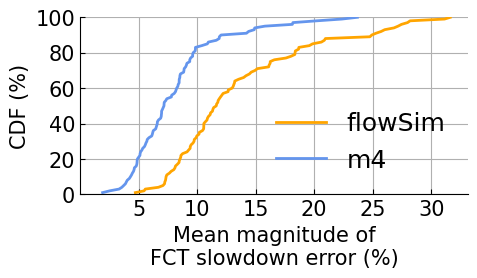

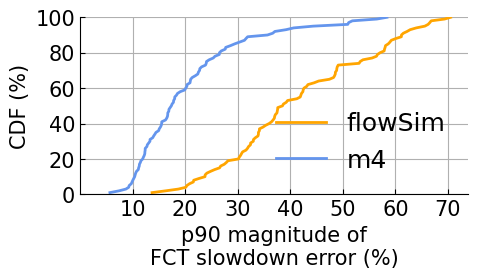

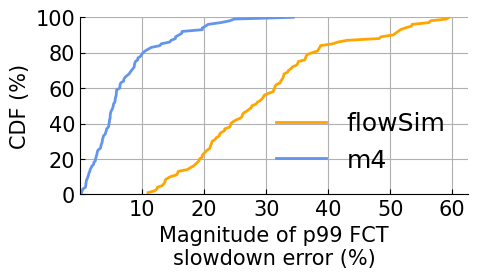

In [23]:
n_scenario=100
empirical_str = "eval_test"
legend_list=['flowSim','m4']
model_instance_list=['flowsim','m4_10']
                     
n_methods = len(legend_list)
config_file=f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/spec/eval_test.mix.json'
configs=json.load(open(config_file))

index_list_ori=[]
for i in range(n_scenario):
    if os.path.exists(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/{empirical_str}/{i}/ns3/flowsim_fct.npy'):
        sizes=np.load(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/{empirical_str}/{i}/ns3/fsize.npy')
        fcts=np.load(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/{empirical_str}/{i}/ns3/fct_topology_flows.npy')
        if sizes.size==fcts.size:
            index_list_ori.append(i)
index_list=[]
config_list=[]
for idx,i in enumerate(index_list_ori):
    config=configs[i]
    spatial=config['spatial'].split('/')[-1].split('.')[0].split('_')[1].upper()
    size_dist=config['size_dist'].split('/')[-1].split('.')[0].split('-')[0]
    cluster=config['cluster'].split('/')[-1].split('.')[0].split('_')
    cluster=f"{cluster[1]} to {cluster[3]}"
    max_load=float(config['max_load'])
    lognorm_sigma=float(config['lognorm_sigma'])
    cc=config['cc'].upper()
    bfsz=float(config['bfsz'])
    fwin=float(config['window'])
    
    config_list.append([spatial, size_dist, cluster, max_load, lognorm_sigma,cc,bfsz,fwin])
    index_list.append(idx)
config_list=np.array(config_list)

error_list=[]
error_list_p90=[]
error_list_p99=[]
for model_instance in model_instance_list:
    data_m4 = np.load(f'./res/{model_instance}{empirical_str}.npz')
    sldn = data_m4['fct']
    predicted_sldns = sldn[index_list, :, 0]
    actual_sldns = sldn[index_list,:, 1]
    print(f"{model_instance}-sldn: {predicted_sldns.shape}")
    
    predicted_sldns[predicted_sldns==0]=1
    actual_sldns[actual_sldns==0]=1
    # calculate the relative error
    relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
    relative_error_sldn_mean=np.mean(relative_error_sldn,axis=1)
    relative_error_sldn_p90=np.percentile(relative_error_sldn,90,axis=1)
    # relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
    sldn_p99_est=np.percentile(predicted_sldns,99,axis=1)
    sldn_p99_act=np.percentile(actual_sldns,99,axis=1)
    
    error_list.append(relative_error_sldn_mean)
    error_list_p90.append(relative_error_sldn_p90)
    error_list_p99.append(np.abs(sldn_p99_est-sldn_p99_act)/sldn_p99_act*100)
error_list=np.array(error_list)
error_list_p90=np.array(error_list_p90)
error_list_p99=np.array(error_list_p99)

print(f"mean error:{[np.mean(x) for x in error_list]}")
print(f"p90 error:{[np.mean(x) for x in error_list_p90]}")
print(f"p99 slowdown error:{[np.mean(x) for x in error_list_p99]}")

fig_idx=0
plot_cdf(
    error_list,
    f"./figs/eva_cdf_mean.pdf",
    legend_list,
    x_label="Mean magnitude of\nFCT slowdown error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=18,
    loc=4,
    enable_abs=True,
    group_size=5,
    colors=["orange",
    "cornflowerblue"],
    fig_idx=fig_idx,
)
fig_idx+=1

plot_cdf(
    error_list_p90,
    f"./figs/eva_cdf_p99.pdf",
    legend_list,
    x_label="p90 magnitude of\nFCT slowdown error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=18,
    loc=4,
    enable_abs=True,
    group_size=5,
    colors=["orange",
    "cornflowerblue"],
    fig_idx=fig_idx,
)
fig_idx+=1

plot_cdf(
    error_list_p99,
    f"./figs/eva_cdf_tailsldn.pdf",
    legend_list,
    x_label="Magnitude of p99 FCT\nslowdown error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=18,
    loc=4,
    enable_abs=True,
    group_size=5,
    colors=["orange",
    "cornflowerblue"],
    fig_idx=fig_idx,
)
fig_idx+=1

flowsim-sldn: (100, 20000)
m4_10-sldn: (100, 20000)
m4_nosize_10-sldn: (100, 20000)
m4_noqueue_10-sldn: (100, 20000)
mean error:[13.66521180499131, 8.09797406245194, 11.056911254362085, 10.051617656749569]
p90 error:[41.53505464899026, 20.53497232051349, 28.462104216127532, 24.97639713908219]
p99 error:[29.58749684315719, 7.255249081337991, 20.97375374738091, 13.612882861363614]


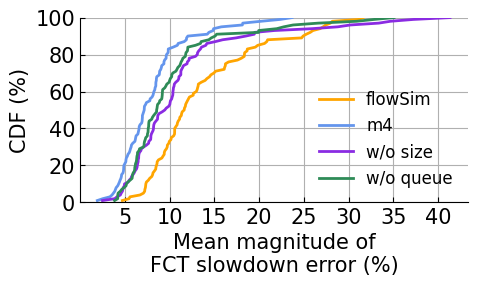

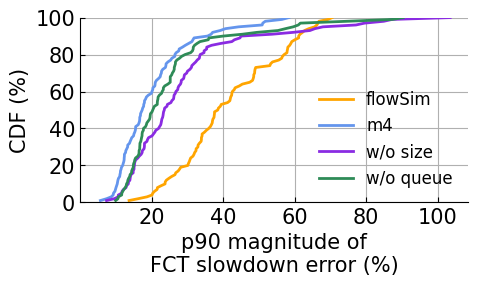

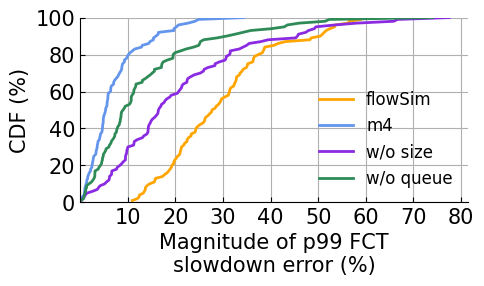

In [25]:
n_scenario=100
empirical_str = "eval_test"
legend_list=['flowSim','m4','w/o size','w/o queue']
model_instance_list=['flowsim','m4_10','m4_nosize_10','m4_noqueue_10']
                     
n_methods = len(legend_list)
config_file=f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/spec/eval_test.mix.json'
configs=json.load(open(config_file))

index_list_ori=[]
for i in range(n_scenario):
    if os.path.exists(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/{empirical_str}/{i}/ns3/flowsim_fct.npy'):
        sizes=np.load(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/{empirical_str}/{i}/ns3/fsize.npy')
        fcts=np.load(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/{empirical_str}/{i}/ns3/fct_topology_flows.npy')
        if sizes.size==fcts.size:
            index_list_ori.append(i)
index_list=[]
config_list=[]
for idx,i in enumerate(index_list_ori):
    config=configs[i]
    spatial=config['spatial'].split('/')[-1].split('.')[0].split('_')[1].upper()
    size_dist=config['size_dist'].split('/')[-1].split('.')[0].split('-')[0]
    cluster=config['cluster'].split('/')[-1].split('.')[0].split('_')
    cluster=f"{cluster[1]} to {cluster[3]}"
    max_load=float(config['max_load'])
    lognorm_sigma=float(config['lognorm_sigma'])
    cc=config['cc'].upper()
    bfsz=float(config['bfsz'])
    fwin=float(config['window'])
    
    config_list.append([spatial, size_dist, cluster, max_load, lognorm_sigma,cc,bfsz,fwin])
    index_list.append(idx)
config_list=np.array(config_list)

error_list=[]
error_list_p90=[]
error_list_p99=[]
for model_instance in model_instance_list:
    data_m4 = np.load(f'./res/{model_instance}{empirical_str}.npz')
    sldn = data_m4['fct']
    predicted_sldns = sldn[index_list, :, 0]
    actual_sldns = sldn[index_list,:, 1]
    print(f"{model_instance}-sldn: {predicted_sldns.shape}")
    
    predicted_sldns[predicted_sldns==0]=1
    actual_sldns[actual_sldns==0]=1
    # calculate the relative error
    relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
    relative_error_sldn_mean=np.mean(relative_error_sldn,axis=1)
    relative_error_sldn_p90=np.percentile(relative_error_sldn,90,axis=1)
    # relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
    sldn_p99_est=np.percentile(predicted_sldns,99,axis=1)
    sldn_p99_act=np.percentile(actual_sldns,99,axis=1)
    
    error_list.append(relative_error_sldn_mean)
    error_list_p90.append(relative_error_sldn_p90)
    error_list_p99.append(np.abs(sldn_p99_est-sldn_p99_act)/sldn_p99_act*100)
config_list=config_list[index_list]
error_list=np.array(error_list)
error_list_p90=np.array(error_list_p90)
error_list_p99=np.array(error_list_p99)

print(f"mean error:{[np.mean(x) for x in error_list]}")
print(f"p90 error:{[np.mean(x) for x in error_list_p90]}")
print(f"p99 error:{[np.mean(x) for x in error_list_p99]}")

fig_idx=0
plot_cdf(
    error_list,
    f"./figs/eva_ablation_mean.pdf",
    legend_list,
    x_label="Mean magnitude of\nFCT slowdown error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=12,
    loc=4,
    enable_abs=True,
    group_size=5,
    colors=["orange",
    "cornflowerblue",
    "blueviolet",
    "seagreen",
    'tomato'],
    fig_idx=fig_idx,
    fig_size=(5,2.4)
)
fig_idx+=1

plot_cdf(
    error_list_p90,
    f"./figs/eva_ablation_p90.pdf",
    legend_list,
    x_label="p90 magnitude of\nFCT slowdown error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=12,
    loc=4,
    enable_abs=True,
    group_size=5,
    colors=["orange",
    "cornflowerblue",
    "blueviolet",
    "seagreen",
    'tomato'],
    fig_idx=fig_idx,
    fig_size=(5,2.4)
)
fig_idx+=1

plot_cdf(
    error_list_p99,
    f"./figs/eva_ablation_tailsldn.pdf",
    legend_list,
    x_label="Magnitude of p99 FCT\nslowdown error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=12,
    loc=4,
    enable_abs=True,
    group_size=5,
    colors=["orange",
    "cornflowerblue",
    "blueviolet",
    "seagreen",
    'tomato'],
    fig_idx=fig_idx,
    fig_size=(5,2.4)
)
fig_idx+=1

# # Discretize the max_load values
# max_load_values = np.array([config[3] for config in config_list], dtype=float)
# bins = [0.3, 0.4,0.5, 0.6, 0.7, 0.8]
# labels = ['30-40', '40-50', '50-60', '60-70', '70-80']
# max_load_bins = np.digitize(max_load_values, bins, right=False) - 1
# max_load_labels = [labels[i] for i in max_load_bins]
# for idx, config in enumerate(config_list):
#     config[3] = max_load_labels[idx]
    
# bfsz_values = np.array([config[6] for config in config_list], dtype=float)
# bfsz_values=bfsz_values*10
# bins = [100,120,140,160,180]
# labels = ['100-120', '120-140', '140-160', '160-180']
# bfsz_bins = np.digitize(bfsz_values, bins, right=False) - 1
# bfz_labels = [labels[i] for i in bfsz_bins]
# for idx, config in enumerate(config_list):
#     config[6] = bfz_labels[idx]

# fwin_values=np.array([config[7] for config in config_list], dtype=float)
# bins = [10000,12000,14000,16000,18000]
# labels = ['10-12', '12-14', '14-16', '16-18']
# fwin_bins = np.digitize(fwin_values, bins, right=False) - 1
# fwin_labels = [labels[i] for i in fwin_bins]
# for idx, config in enumerate(config_list):
#     config[7] = fwin_labels[idx]
# # Convert config_list to a NumPy array for easier indexing
# config_list = np.array(config_list)

# # Generate plots for each configuration attribute
# config_attributes = ["Traffic matrix", "Flow size distribution", "Oversubscription", "Max load (%)", "Burstiness (log-normal's $\sigma$)", "Congestion control algorithm", "Buffer size (KB)", "Init. window size (KB)"]
# error_list=error_list.T
# for i, config_name in enumerate(config_attributes):
#     plot_box_by_config(error_list, legend_list if i==0 else None,n_methods=len(legend_list),config_list=config_list, config_index=i, config_name=config_name,fig_idx=fig_idx,loc=1,file_name=None,y_label="Mean magnitude of\nFCT slowdown error (%)")
#     fig_idx+=1

In [ ]:
bo

S=0, N=1, #flows: 20000, end_time: 380547060.0
S=0, N=1, #flows: 19716, end_time: 1997734684.0
S=0, N=1, #flows: 20000, end_time: 1079987365.0
S=0, N=1, #flows: 20000, end_time: 129346528.0
S=0, N=1, #flows: 20000, end_time: 745600350.0
S=0, N=1, #flows: 20000, end_time: 655191531.0
S=0, N=1, #flows: 19992, end_time: 106221925.0
S=0, N=1, #flows: 19979, end_time: 618436039.0
S=0, N=1, #flows: 20000, end_time: 560738719.0
S=0, N=1, #flows: 19959, end_time: 139591924.0
S=0, N=1, #flows: 19926, end_time: 618030116.0
mean error in application, m4: 0.11504051958359345, flowsim: 0.28109050369390337
p90 error in application, m4: 0.22267596173529064, flowsim: 0.49933623940831406
throughput_list: (105,)



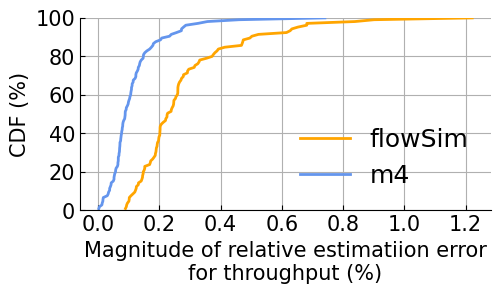

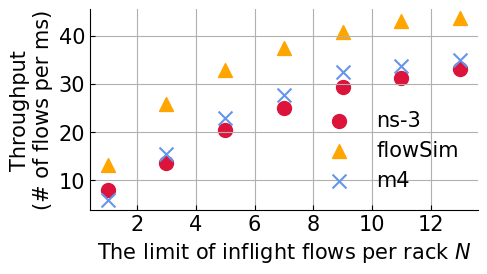

In [30]:
n_scenario=105
#empirical_str = "eval_test_app"
empirical_str = "eval_app"
legend_list=['ns-3','m4', 'flowsim']
#N_list=[1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
N_list = [1, 3, 5, 7, 9, 11, 13]
# N_list = [1, 3, 5, 7, 9, 11]
root_dir=f"/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/{empirical_str}"

config_file=f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/spec/{empirical_str}.mix.json'
configs=json.load(open(config_file))

throughput_list=[]
m4_throughput_list = []
flowsim_throughput_list = []
m4_error = []
flowsim_error = []
for i in range(n_scenario):
    if os.path.exists(f'{root_dir}/{i}/ns3/fct_topology_flows.npy'):
        file_path=f"{root_dir}/{i}/ns3/fct_topology_flows.txt"
        m4_path = f"{root_dir}/{i}/ns3/m4_fct.npy"
        with open(file_path, "r") as file:
            reader = csv.reader(file, delimiter=" ")
            fats, fcts = [], []
            for row in reader:
                # Remove empty strings caused by multiple spaces
                cleaned_row = [item for item in row if item.strip() != ""]
                # Extract the last third and second columns
                if len(cleaned_row) >= 3:
                    fats.append(cleaned_row[-3])
                    fcts.append(cleaned_row[-2])
            
            # Convert to numpy arrays and calculate throughput
            fats = np.array(fats).astype(np.int64)
            fcts = np.array(fcts).astype(np.int64)
            end_time = np.max(fats + fcts)-1e9
            if i%10==0:
                print(f"S=0, N={N_list[i%10]}, #flows: {len(fats)}, end_time: {end_time}")
            throughput = len(fats) / (end_time / 1e6)
            throughput_list.append(throughput)

            fids = np.load(f"{root_dir}/{i}/ns3/fid_topology_flows.npy")

            m4_fats = np.load(f"{root_dir}/{i}/ns3/m4_release_times.npy")
            m4_fcts = np.load(f"{root_dir}/{i}/ns3/m4_fct.npy")
            m4_end_time = np.max(m4_fcts + m4_fats) - 1e9
            m4_throughput = len(m4_fats) / (m4_end_time / 1e6)
            m4_throughput_list.append(m4_throughput)

            m4_error.append(abs(m4_throughput - throughput) / throughput)

            flowsim_fats = np.load(f"{root_dir}/{i}/ns3/flowsim_release_times.npy")
            flowsim_fcts = np.load(f"{root_dir}/{i}/ns3/app_flowsim_fct.npy")
            flowsim_end_time = np.max(flowsim_fcts + flowsim_fats) - 1e9
            flowsim_throughput = len(flowsim_fats) / (flowsim_end_time / 1e6)
            flowsim_throughput_list.append(flowsim_throughput)

            flowsim_error.append(abs(flowsim_throughput - throughput) / throughput)
        
            
throughput_list=np.array(throughput_list)
m4_throughput_list = np.array(m4_throughput_list)
flowsim_throughput_list = np.array(flowsim_throughput_list)

m4_error = np.array(m4_error)
flowsim_error = np.array(flowsim_error)
print("mean error in application, m4: {}, flowsim: {}".format(np.mean(m4_error), np.mean(flowsim_error)))
print("p90 error in application, m4: {}, flowsim: {}".format(np.percentile(m4_error,90), np.percentile(flowsim_error,90)))
print(f"throughput_list: {throughput_list.shape}")
fig_idx=0
plot_cdf(
    [flowsim_error,m4_error],
    f"./figs/eva_app_cdf.pdf",
    # None,
    ["flowSim","m4"],
    x_label="Magnitude of relative estimatiion error\nfor throughput (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    # xlim_bottom=0.01,
    fontsize=15,
    legend_font=18,
    loc=4,
    enable_abs=True,
    group_size=5,
    colors=["orange",
    "cornflowerblue", "purple"],
    fig_idx=fig_idx,
    fig_size=(5.3,2.5)
)
fig_idx+=1

# Group scenarios into configurations
group_size = len(N_list)
num_configs = len(throughput_list) // group_size
config_labels = [f"$S$={n}" for n in range(num_configs)]

print(f"")
raw_data=[]
m4_raw_data = []
flowsim_raw_data = []
for i in range(num_configs):
    tmp=[]
    m4_tmp=[]
    flowsim_tmp=[]
    for j in range(group_size):
        tmp.append(throughput_list[j*num_configs+i])
        m4_tmp.append(m4_throughput_list[j*num_configs+i])
        flowsim_tmp.append(flowsim_throughput_list[j*num_configs+i])
    tmp=np.array(tmp)
    m4_tmp = np.array(m4_tmp)
    flowsim_tmp = np.array(flowsim_tmp)
    raw_data.append((N_list,tmp))
    m4_raw_data.append((N_list, m4_tmp))
    flowsim_raw_data.append((N_list, flowsim_tmp))

# Plot the data
for i in [9]:
    plot_scatter(
        [raw_data[i], flowsim_raw_data[i],m4_raw_data[i]],
        # file_name=None,
        file_name='./figs/eva_app_scatter.pdf',
        linelabels=["ns-3", "flowSim","m4"],
        x_label="The limit of inflight flows per rack $N$",
        y_label="Throughput\n(# of flows per ms)",
        log_switch=False,
        rotate_xaxis=False,
        ylim=None,
        xlim=None,
        fontsize=15,
        legend_font=15,
        loc=4,
        legend_cols=1,
        # title="Throughput Across Scenarios",
        fig_size=(5, 2.6),
        colors=["crimson",
            "orange",
            "cornflowerblue"],  # Example colors
        fig_idx=fig_idx,
        marker_size=100
    )
    fig_idx+=1
# plot_lines(
#     raw_data=[raw_data[5]],
#     file_name=None,
#     linelabels=config_labels,
#     x_label="The limit of inflight flows per rack $N$",
#     y_label="Throughput (# of flows per us)",
#     log_switch=False,
#     rotate_xaxis=False,
#     ylim=None,
#     xlim=None,
#     fontsize=15,
#     legend_font=15,
#     loc=2,
#     legend_cols=1,
#     # title="Throughput Across Scenarios",
#     fig_size=(7, 4),
#     colors=["orange", "cornflowerblue", "green", "purple", "red"],  # Example colors
#     fig_idx=fig_idx,
# )
# plt.show()


In [18]:
# calcaute the per-flow error for the applicaiton with closed-loop traffic
n_scenario=90
empirical_str = "eval_app"
legend_list=['flowSim','m4']
model_instance_list=['flowsim','m4_10']
                     
n_methods = len(legend_list)
config_file=f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/spec/{empirical_str}.mix.json'
configs=json.load(open(config_file))

index_list_ori=[]
for i in range(n_scenario):
    if os.path.exists(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/{empirical_str}/{i}/ns3/fct_topology_flows.npy'):
        index_list_ori.append(i)
index_list=index_list_ori
print(f"index_list: {len(index_list)}")
error_list=[]
error_list_p99=[]
for model_instance in model_instance_list:
    data_m4 = np.load(f'./res/{model_instance}{empirical_str}.npz')
    sldn = data_m4['fct']
    predicted_sldns = sldn[index_list, :, 0]
    actual_sldns = sldn[index_list,:, 1]
    print(f"{model_instance}-sldn: {predicted_sldns.shape}")
    
    predicted_sldns[predicted_sldns==0]=1
    actual_sldns[actual_sldns==0]=1
    # calculate the relative error
    relative_error_sldn = np.mean(np.abs(actual_sldns - predicted_sldns) / actual_sldns *100, axis=1)
    # relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
    sldn_p99_est=np.percentile(predicted_sldns,99,axis=1)
    sldn_p99_act=np.percentile(actual_sldns,99,axis=1)
    
    error_list.append(relative_error_sldn)
    error_list_p99.append(np.abs(sldn_p99_est-sldn_p99_act)/sldn_p99_act*100)
error_list=np.array(error_list)
error_list_p99=np.array(error_list_p99)

print(f"p95 error:{[np.percentile(x,95) for x in error_list]}")
print(f"mean error:{[np.mean(x) for x in error_list]}")
print(f"median error:{[np.median(x) for x in error_list]}")
print(f"tail slowdown error:{[np.mean(x) for x in error_list_p99]}")

fig_idx=0
plot_cdf(
    error_list,
    f"./figs/eva_cdf_mean.pdf",
    legend_list,
    x_label="Mean magnitude of\nFCT slowdown error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=18,
    loc=4,
    enable_abs=True,
    group_size=5,
    colors=["orange",
    "cornflowerblue"],
    fig_idx=fig_idx,
)
fig_idx+=1

plot_cdf(
    error_list_p99,
    f"./figs/eva_cdf_p99.pdf",
    legend_list,
    x_label="Magnitude of p99 FCT\nslowdown error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=18,
    loc=4,
    enable_abs=True,
    group_size=5,
    colors=["orange",
    "cornflowerblue"],
    fig_idx=fig_idx,
)
fig_idx+=1


# Group scenarios into configurations
group_size = 10
num_configs = len(index_list) // group_size
config_labels = [f"$N$={i}" for i in range(num_configs)]

# Reorganize error data by configurations
bucketed_data = []  # Shape: [configs][methods][errors]
for method_idx in range(len(error_list)):
    method_data = []
    for i in range(num_configs):
        start_idx = i * group_size
        end_idx = start_idx + group_size
        method_data.append(error_list[method_idx][start_idx:end_idx])
    bucketed_data.append(method_data)

# Transpose bucketed_data to match [configs][scenarios_per_config]
bucketed_data = list(map(list, zip(*bucketed_data)))

# Plot boxplots for each method grouped by configurations
plot_grouped_boxplots(
    bucketed_data=bucketed_data,
    bucket_labels=config_labels,
    scenario_labels=legend_list,
    # file_name="./figs/grouped_boxplots_configs.pdf",
    file_name=None,
    x_label="The limit of inflight flows per rack $N$",
    y_label="Mean magnitude of\nFCT slowdown error (%)",
    fontsize=13,
    legend_font=15,
    loc="upper left",
    colors=["orange", "cornflowerblue"],
    fig_size=(6, 4),
    # box_width=0.15,
    fig_idx=fig_idx,
    y_ticklabel_fontsize=15,
)


index_list: 90


FileNotFoundError: [Errno 2] No such file or directory: './res/flowsimeval_app.npz'